# Quora question pairs.

In [0]:
%matplotlib inline
%tensorflow_version 1.x
from __future__ import print_function
import numpy as np
import pandas as pd
import datetime, time, json

from keras.models import Model
from keras.layers import Input, TimeDistributed, Dense, Lambda, concatenate, Dropout, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf 
from sklearn.metrics import roc_auc_score
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import functools
from keras import backend as K
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

import warnings
warnings.filterwarnings('ignore')

In [3]:
print(tf.__version__)

1.15.0


In [0]:
def as_keras_metric(method):
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        ''' Wrapper for turning tensorflow metrics into keras metrics '''
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

In [0]:
def classification_and_confusion_report(actual_label,predicted_label,threshold):
    ''' Compute confusion matrix and classification report for 
    given actual and predicted labels. '''
    predicted_label = np.where(predicted_label>threshold,1,0)
    report=classification_report(actual_label,predicted_label)
    cm = confusion_matrix(actual_label,predicted_label)
    print(cm)
    print(report)

#Importing dataset.

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
question_pairs = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/capstone2/quora_questions_similarity/train.csv')
question_pairs.dropna(axis=0,
                      inplace=True)

In [8]:
question_pairs.shape

(404287, 6)

In [9]:
question_pairs.head(3)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0


#Parameters.

In [0]:
MAX_SEQUENCE_LENGTH=20
                         
NB_WORDS = 1500          
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.1
NB_EPOCHS = 10
DROPOUT = 0.1
BATCH_SIZE = 32

#Getting some basic informaion about the dataset.

In [0]:
question1_length = [len(q.split()) for q in question_pairs.question1]
question2_length = [len(q.split()) for q in question_pairs.question2]

max_question1_length = max(question1_length)
max_question2_length = max(question2_length)

In [12]:
print('Maximum question length in question 1:', max_question1_length)
print('Maximum question length in question 2:',max_question2_length)

Maximum question length in question 1: 125
Maximum question length in question 2: 237


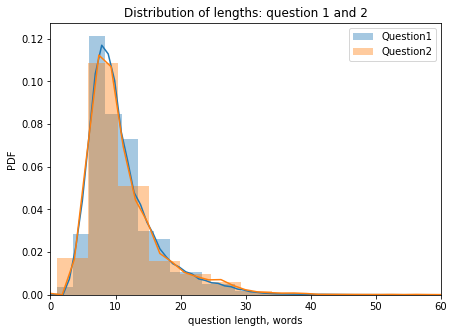

In [13]:
fig, ax = plt.subplots(figsize=(7, 5))

ax = sns.distplot(question1_length,
                  kde=True, 
                  hist = True,
                  label = 'Question1')

ax = sns.distplot(question2_length,
                  kde=True, 
                  hist = True,
                  label = 'Question2')

ax.set(xlabel='question length, words', ylabel='PDF', 
       title = 'Distribution of lengths: question 1 and 2')
ax.set_xlim(0,60)

plt.legend()
plt.show()

In [14]:
word_counts = Counter()

question1 = question_pairs.question1.values.tolist()

for q in question_pairs.question1:
    words = q.split()
    word_counts.update(words)

for q in question_pairs.question2:
    words = q.split()
    word_counts.update(words)
    
print('Vocabulary size:', len(word_counts))

Vocabulary size: 232531


#Jaccard and Cosine similarity.

In [0]:
def match_count(q1,q2):
    ''' Returns Jaccard similarity of two datasets. '''
    set_1 = set(q1)
    set_2 = set(q2)
    set_3 = set_1.intersection(set_2)
    return len(set_3)/(len(set_1)+len(set_2)-len(set_3))  

In [0]:
question_pairs.question1 = question_pairs.question1.str.lower()
question_pairs.question2 = question_pairs.question2.str.lower()

question_pairs['char_match_count']= \
    question_pairs.apply(lambda row: match_count(row['question1'],row['question2']),
                         axis=1)
question_pairs['word_match_count'] = \
    question_pairs.apply(lambda row: match_count(row['question1'].split(),row['question2'].split()),
                         axis=1)

In [0]:
import re, math
from collections import Counter

def get_cosine(vec1, vec2):
    ''' Calculate cosine similarity between two vectors,
    each vector is dictionary with key and value word:count.'''
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x]**2 for x in vec1.keys()])
    sum2 = sum([vec2[x]**2 for x in vec2.keys()])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator

def text_to_vector(text):
    words = re.compile(r'\w+').findall(text)
    return Counter(words)

In [0]:
question_pairs['cosine_similarity']= \
    question_pairs.apply(lambda row: get_cosine(text_to_vector(row['question1']),
                                       text_to_vector(row['question2'])),
                         axis=1)

In [20]:
question_pairs.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,char_match_count,word_match_count,cosine_similarity
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1.000000,0.769231,0.944911
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,0.703704,0.250000,0.613572
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.750000,0.200000,0.338062


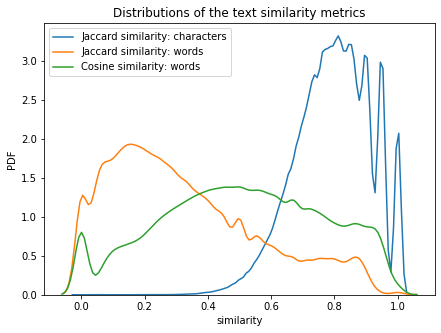

In [21]:
fig, ax = plt.subplots(figsize=(7, 5))

ax = sns.distplot(question_pairs.char_match_count, 
                  bins=int(np.sqrt(len(question_pairs.char_match_count))), 
                  kde=True, 
                  hist = False,
                  label = 'Jaccard similarity: characters')
ax = sns.distplot(question_pairs.word_match_count, 
                  bins=int(np.sqrt(len(question_pairs.word_match_count))), 
                  kde=True,
                  hist = False,
                  label = 'Jaccard similarity: words')
ax = sns.distplot(question_pairs.cosine_similarity, 
                  bins=int(np.sqrt(len(question_pairs.cosine_similarity))), 
                  kde=True, 
                  hist = False,
                  label = 'Cosine similarity: words')

ax.set(xlabel='similarity', ylabel='PDF', 
       title = 'Distributions of the text similarity metrics')

plt.legend()
plt.show()

#Train-test split.

In [0]:
msk = np.random.rand(len(question_pairs)) < TEST_SPLIT
train = question_pairs[~msk]
test = question_pairs[msk]

#Tokenize dataset.

In [0]:
# 1500 words are taken in consideration in the model.
tokenizer = Tokenizer(num_words = NB_WORDS)

# Fit on vocabulary used in both question1 and question2 on train dataset.
tokenizer.fit_on_texts(np.concatenate((train.question1.astype(str), 
                                       train.question2.astype(str)),
                                      axis=0))

# Covert texts to sequences on questions 1 and 2, in train and test dataset.
sequences_train_q1 = tokenizer.texts_to_sequences(train.question1.astype(str))
sequences_train_q2 = tokenizer.texts_to_sequences(train.question2.astype(str))

sequences_test_q1 = tokenizer.texts_to_sequences(test.question1.astype(str))
sequences_test_q2 = tokenizer.texts_to_sequences(test.question2.astype(str))

word_index = tokenizer.word_index

#Pad sequences.

In [0]:
sequences_train_q1_padded = pad_sequences(sequences_train_q1, maxlen=MAX_SEQUENCE_LENGTH)
sequences_train_q2_padded = pad_sequences(sequences_train_q2, maxlen=MAX_SEQUENCE_LENGTH)

sequences_test_q1_padded = pad_sequences(sequences_test_q1, maxlen=MAX_SEQUENCE_LENGTH)
sequences_test_q2_padded = pad_sequences(sequences_test_q2, maxlen=MAX_SEQUENCE_LENGTH)

#Generate word embedding matrix using pretrained GloVe embeddings.

In [0]:
word_embedding_matrix = np.zeros((NB_WORDS+1, EMBEDDING_DIM))

embeddings_index = {}

#Using pre-trained word vectors.
pre_trained_glove_vecs = open('/content/gdrive/My Drive/Colab Notebooks/capstone2/quora_questions_similarity/glove.6B.50d.txt',
                              encoding="utf-8")

for line in pre_trained_glove_vecs:
    values = line.split()
    word = values[0] #gives the word for which vector is given
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    
pre_trained_glove_vecs.close()

for word, i in word_index.items():
    if i >= NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        word_embedding_matrix[i] = embedding_vector

# One shot learning with Siamese network.



In [0]:
K.clear_session()
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Flatten
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

question1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
question2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

features  = Input(shape=(3,))

q1 = Embedding(NB_WORDS + 1, 
               EMBEDDING_DIM, 
               weights=[word_embedding_matrix], 
               input_length=MAX_SEQUENCE_LENGTH, 
               trainable=True)(question1)

#q1 = Bidirectional(LSTM(30), merge_mode="sum")(q1)
q1 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(q1)

q1_max_embedding_dim = Lambda(lambda x: K.max(x, axis=1), output_shape=(MAX_SEQUENCE_LENGTH, ))(q1)
q1_max_sequence_dim = Lambda(lambda x: K.max(x, axis=2), output_shape=(EMBEDDING_DIM, ))(q1)

q1_sum_embedding_dim = Lambda(lambda x: K.sum(x, axis=1), output_shape=(MAX_SEQUENCE_LENGTH, ))(q1)
q1_sum_sequence_dim = Lambda(lambda x: K.sum(x, axis=2), output_shape=(EMBEDDING_DIM, ))(q1)

q2 = Embedding(NB_WORDS + 1, 
               EMBEDDING_DIM, 
               weights=[word_embedding_matrix], 
               input_length=MAX_SEQUENCE_LENGTH, 
               trainable=True)(question2)

#q2 = Bidirectional(LSTM(30), merge_mode="sum")(q2)
q2 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(q2)

q2_max_embedding_dim = Lambda(lambda x: K.max(x, axis=1), output_shape=(MAX_SEQUENCE_LENGTH, ))(q2)
q2_max_sequence_dim = Lambda(lambda x: K.sum(x, axis=2), output_shape=(EMBEDDING_DIM, ))(q2)

q2_sum_embedding_dim = Lambda(lambda x: K.sum(x, axis=1), output_shape=(MAX_SEQUENCE_LENGTH, ))(q2)
q2_sum_sequence_dim = Lambda(lambda x: K.sum(x, axis=2), output_shape=(EMBEDDING_DIM, ))(q2)

#q2 = Flatten()(q2)

#functional keras code instead of the normal sequential code
merged = concatenate([q1_max_embedding_dim,
                      q2_max_embedding_dim,
                      q1_sum_embedding_dim,
                      q2_sum_embedding_dim,
                      q1_sum_sequence_dim,
                      q2_sum_sequence_dim,
                      q1_max_sequence_dim,
                      q2_max_sequence_dim,
                      features])
merged = Dense(300, activation='relu')(merged)
merged = Dropout(0.5)(merged)
merged = BatchNormalization()(merged)
merged = Dense(100, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = BatchNormalization()(merged)
merged = Dense(100, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = BatchNormalization()(merged)
merged = Dense(50, activation='relu')(merged)
merged = Dropout(0.1)(merged)
merged = BatchNormalization()(merged)

is_duplicate = Dense(1, activation='sigmoid')(merged)

one_shot_model = Model(inputs=[question1,question2,features], 
                       outputs=is_duplicate)

auc_roc = as_keras_metric(tf.metrics.auc)
one_shot_model.compile(loss='binary_crossentropy', 
                       optimizer='adam', 
                       metrics=[auc_roc])

In [30]:
one_shot_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20, 50)       75050       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 20, 50)       75050       input_2[0][0]                    
____________________________________________________________________________________________

In [0]:
import keras
tbCallBack = keras.callbacks.TensorBoard(log_dir='/content/gdrive/My Drive/Colab Notebooks/capstone2/quora_questions_similarity/Graph', 
                                         histogram_freq=0,  
                                         write_graph=True, 
                                         write_images=True)

In [0]:
train_features=train[['char_match_count','word_match_count','cosine_similarity']]

In [34]:
deprecation._PRINT_DEPRECATION_WARNINGS = False
one_shot_model_history = one_shot_model.fit([sequences_train_q1_padded, 
                                             sequences_train_q2_padded,
                                             train_features],
                                            train.is_duplicate,
                                            epochs=NB_EPOCHS,
                                            validation_split=VALIDATION_SPLIT,
                                            batch_size=BATCH_SIZE,
                                            callbacks=[tbCallBack],
                                            initial_epoch = 0)

Train on 327619 samples, validate on 36403 samples
Epoch 1/10
327619/327619 [==============================] - 130s 395us/step - loss: 0.4837 - auc: 0.7673 - val_loss: 0.4494 - val_auc: 0.7992

Epoch 2/10
327619/327619 [==============================] - 129s 395us/step - loss: 0.4663 - auc: 0.8111 - val_loss: 0.4474 - val_auc: 0.8189
Epoch 3/10
327619/327619 [==============================] - 129s 393us/step - loss: 0.4592 - auc: 0.8241 - val_loss: 0.4396 - val_auc: 0.8281
Epoch 4/10
327619/327619 [==============================] - 128s 390us/step - loss: 0.4542 - auc: 0.8312 - val_loss: 0.4271 - val_auc: 0.8339
Epoch 5/10
327619/327619 [==============================] - 126s 386us/step - loss: 0.4500 - auc: 0.8362 - val_loss: 0.4262 - val_auc: 0.8380
Epoch 6/10
327619/327619 [==============================] - 127s 388us/step - loss: 0.4474 - auc: 0.8397 - val_loss: 0.4289 - val_auc: 0.8411
Epoch 7/10
327619/327619 [==============================] - 126s 385us/step - loss: 0.4442 - auc

In [0]:
import matplotlib.pyplot as plt
def plot_train_valid(model_history):
    hist = model_history.history
    x_arr = np.arange(len(hist['loss'])) + 1

    fig = plt.figure(figsize=(16, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist['auc'], '-o', label='Train acc.')
    ax.plot(x_arr, hist['val_auc'], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('AUC', size=15)

    return plt.show()

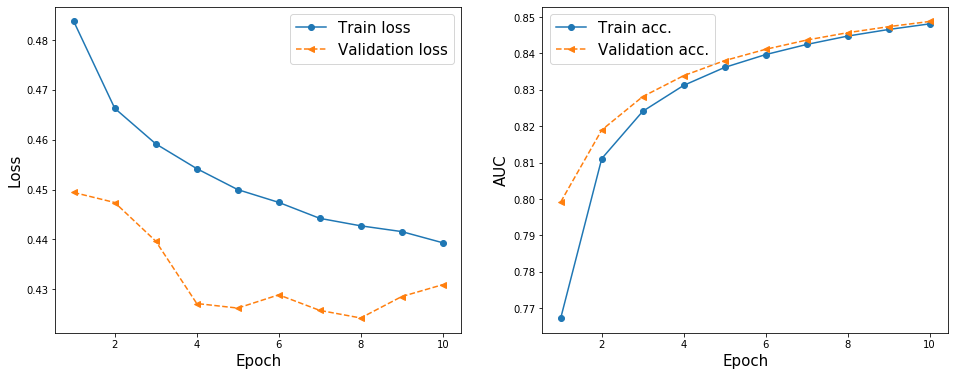

In [36]:
plot_train_valid(one_shot_model_history)

#Performance on the test set.

In [0]:
test_data_features=test[['char_match_count','word_match_count','cosine_similarity']]
y_pred = one_shot_model.predict([sequences_test_q1_padded, 
                                 sequences_test_q2_padded,
                                 test_data_features])

In [38]:
classification_and_confusion_report(test.is_duplicate,y_pred,0.5)

[[22913  2477]
 [ 6864  8011]]
              precision    recall  f1-score   support

           0       0.77      0.90      0.83     25390
           1       0.76      0.54      0.63     14875

    accuracy                           0.77     40265
   macro avg       0.77      0.72      0.73     40265
weighted avg       0.77      0.77      0.76     40265

